FROM KARRIE and DAVID

In [3]:
from astroquery.mast import Observations
from astrowidgets import ImageWidget

from astropy import units as u
from astropy.io import fits
from astropy import table
from astropy.coordinates import SkyCoord

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# For M31: PHAT Catalogs

In [435]:
# Read in the brick-wide st catalog of your choice
# st catalog is best case scenario in terms of crowding, since some detected sources not included

# files downloaded from MAST 
# https://archive.stsci.edu/prepds/phat/datalist.html

# *.st.fits: Star files: these files contain the photometry of all
# objects classified as stars (object type <= 2 and sharp_filter^2 <
# 0.1) with S/N > 4 in at least one band and data flag < 8.  All objects
# with S/N > 4 in both filters are also included in these files.  These
# files will contain more objects but will have less clean CMD features.

# Brick 19: approximately the equivalent of the solar neighborhood, adjusting for relative scale lengths
phat_cat = 'hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12110-m31-b19_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits'
phat_ref_img = 'hlsp_phat_hst_wfc3-ir_12110-m31-b19_f110w_v1_drz.fits'

# Brick 23: most conservative option
phat_cat = 'hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12070-m31-b23_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits'
phat_ref_img = 'hlsp_phat_hst_wfc3-ir_12070-m31-b23_f110w_v1_drz.fits'

# Brick 11
#phat_cat = 'hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12115-m31-b11_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits'

hdu_list = fits.open(phat_cat, memmap=True) # memmap helps prevent RAM issues for big files

In [436]:
hdu_list.info()
print(hdu_list[1].columns)

Filename: hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_12070-m31-b23_f275w-f336w-f475w-f814w-f110w-f160w_v2_st.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    162   2756854R x 77C   [E, E, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, L, L, L, L, L, L, K, E, E, L, L, L, L]   
ColDefs(
    name = 'x'; format = 'E'
    name = 'y'; format = 'E'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'f110w_rate'; format = 'E'
    name = 'f110w_raterr'; format = 'E'
    name = 'f110w_vega'; format = 'E'
    name = 'f110w_err'; format = 'E'
    name = 'f110w_chi'; format = 'E'
    name = 'f110w_snr'; format = 'E'
    name = 'f110w_sharp'; format = 'E'
    name = 'f110w_round'; format = 'E'
    name = 'f110w_crowd'; format = 'E'
    name =

In [437]:
phat_data = table.Table(hdu_list[1].data)

In [438]:
phat_data

x,y,ra,dec,f110w_rate,f110w_raterr,f110w_vega,f110w_err,f110w_chi,f110w_snr,f110w_sharp,f110w_round,f110w_crowd,f110w_flag,f160w_rate,f160w_raterr,f160w_vega,f160w_err,f160w_chi,f160w_snr,f160w_sharp,f160w_round,f160w_crowd,f160w_flag,f275w_rate,f275w_raterr,f275w_vega,f275w_err,f275w_chi,f275w_snr,f275w_sharp,f275w_round,f275w_crowd,f275w_flag,f336w_rate,f336w_raterr,f336w_vega,f336w_err,f336w_chi,f336w_snr,f336w_sharp,f336w_round,f336w_crowd,f336w_flag,f475w_rate,f475w_raterr,f475w_vega,f475w_err,f475w_chi,f475w_snr,f475w_sharp,f475w_round,f475w_crowd,f475w_flag,f814w_rate,f814w_raterr,f814w_vega,f814w_err,f814w_chi,f814w_snr,f814w_sharp,f814w_round,f814w_crowd,f814w_flag,f275w_gst,f336w_gst,f475w_gst,f814w_gst,f110w_gst,f160w_gst,field,ir_x,ir_y,inside_ir,inside_brick,inside_chipgap,inside_other_chipgap
float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,bool,bool,bool,bool,bool,int64,float32,float32,bool,bool,bool,bool
3177.67,2512.01,11.840254697,42.2849569026,1.82e-06,3.41e-10,14.35,0.0,1.01,5331.1,-0.017,0.006,0.062,0,2.7e-06,5.56e-10,13.92,0.0,1.48,4859.6,0.021,0.012,0.076,0,3.31e-08,2.05e-10,18.699,0.007,2.95,161.9,0.022,0.068,0.003,0,2.25e-07,3.24e-10,16.618,0.002,3.12,695.5,0.034,0.061,0.008,0,2.92e-07,1.14e-09,16.337,0.004,8.91,256.2,-0.149,0.038,0.015,0,1.34e-06,2.81e-09,14.686,0.002,2.68,475.4,0.027,-0.052,0.0,0,True,True,True,True,True,True,1,932.9,290.586,True,True,False,False
2870.29,2914.33,11.8307509203,42.285140768,3.45e-07,1.45e-10,16.154,0.0,0.88,2386.8,-0.016,-0.017,0.0,0,5.78e-07,2.49e-10,15.596,0.0,1.32,2317.5,0.004,0.003,0.0,0,3.84e-09,7.4e-11,21.038,0.021,2.91,52.0,0.092,0.037,0.0,0,2.89e-08,1.16e-10,18.847,0.004,3.82,249.0,-0.011,0.071,0.0,0,5.38e-08,7.84e-11,18.173,0.002,2.16,686.6,-0.003,0.051,0.0,0,2.22e-07,1.16e-09,16.634,0.006,1.84,192.1,0.053,0.012,0.0,0,True,True,True,True,True,True,1,955.849,498.257,True,True,False,False
2521.57,2350.79,11.8354850854,42.2936515958,2.59e-07,1.26e-10,16.468,0.001,1.57,2058.7,-0.017,0.067,0.0,0,5.09e-07,2.34e-10,15.732,0.0,1.26,2176.6,-0.003,0.001,0.0,0,-1e-12,1.81e-11,99.999,9.999,1.17,-0.1,3.901,-0.305,0.0,0,1.18e-09,2.55e-11,22.321,0.023,3.08,46.3,0.06,0.122,0.0,0,8.25e-09,1.48e-11,20.209,0.002,1.3,558.9,0.042,0.002,0.0,0,1.23e-07,8.74e-10,17.272,0.008,1.23,141.2,-0.003,-0.055,0.0,0,True,True,True,True,True,True,1,718.266,433.712,True,True,False,False
1322.63,3754.0,11.800935575,42.2957151044,3.18e-07,1.42e-10,16.245,0.0,0.8,2237.1,0.0,-0.017,0.058,0,5e-07,2.38e-10,15.753,0.001,0.77,2098.0,0.022,0.023,0.07,0,8.13e-09,1.04e-10,20.225,0.014,2.27,78.4,0.046,-0.068,0.0,0,4.53e-08,1.45e-10,18.359,0.003,3.1,312.5,0.031,0.062,0.002,0,5.89e-08,5.94e-11,18.074,0.001,3.8,992.1,-0.052,-0.016,0.028,0,2.15e-07,1.16e-09,16.67,0.006,2.42,184.8,0.007,0.12,0.058,0,True,True,True,True,True,True,1,771.864,212.909,False,True,False,True
3177.56,2509.94,11.8402849744,42.284974996,1.26e-07,2.17e-10,17.252,0.002,17.27,580.5,-0.082,0.118,1.976,0,2.17e-07,3.82e-10,16.656,0.002,22.35,569.1,0.305,0.165,2.033,0,1.65e-10,5.44e-11,24.453,0.358,4.22,3.0,-1.27,1.446,2.925,0,3.22e-09,8.41e-11,21.232,0.029,15.36,38.1,-0.727,1.287,1.706,0,7.03e-09,3.75e-10,20.383,0.058,13.01,18.8,-0.817,0.218,1.505,0,-7.6e-08,9.18e-10,99.999,0.009,14.64,-83.3,0.0,0.0,9.999,0,False,False,False,True,True,True,1,932.336,290.009,True,True,False,False
851.23,2162.69,11.8199528171,42.3139759662,1.33e-07,9.14e-11,17.192,0.001,1.21,1452.1,-0.024,0.022,0.017,0,2.09e-07,1.56e-10,16.698,0.001,1.3,1344.7,-0.002,0.013,0.03,0,4.03e-09,7.53e-11,20.988,0.02,3.87,53.5,-0.039,-0.035,

# Check if star is acceptable

In [439]:
## E's values from running ETC for M32 catalog (optical filters)
#saturation_limit = 19.2 # according to ETC in F110W with NSRAPID  #vegamag is 19.2 abmag is 19.5
#faint_limit = 23.2 # S/N > 20 in F110W with NSRAPID # vegamag is 23.2 abmag is 23.5
#companion_mag_cutoff = 26

# K's values from running ETC for PHAT catalog
saturation_limit = 19.0 # according to ETC - source mag in vegamag F110W WFC3/IR, strategy: with NSRAPID in F110W
# using JDOX table - this is a more conservative choice
saturation_limit = 19.5 

faint_limit = 22.1 # S/N > 20 according to ETC; vegamag F110W WFC3/IR, with NSRAPID in F110W
# unlike saturation limit, above is approx. the same as the JDOX table, which is 22.0 in F110W NIRSpec
faint_limit_for_mag_contrast = faint_limit + 2  # this *must* be fainter than faint_limit for the code below to work right
companion_mag_cutoff = faint_limit + 10.  # this is for determining what counts when looking for companions within 0.3 arcsec

In [440]:
#msata_stars = t814[(t814['MagAp2'] < faint_limit)&(t814['Flags'] == 0)]
#len(msata_stars)

# Is the star bright enough to use for TA, and is it well measured? (passes gst cuts)
msata_stars = phat_data[(phat_data['f110w_vega'] < faint_limit)&(phat_data['f110w_gst'] == True)]
# could also try without enforcing 'gst' cut- 
# but that makes an insignificant difference in total available # of stars, at least for Brick 23
msata_stars = phat_data[(phat_data['f110w_vega'] < faint_limit)]
len(msata_stars)

45864

In [441]:
starcoos = SkyCoord.guess_from_table(msata_stars, unit=u.deg)

## Density 

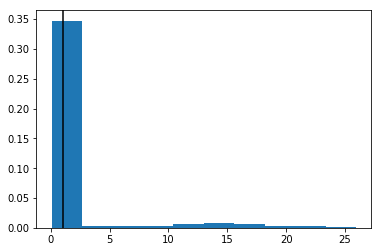

In [442]:
searchsep = 2*u.arcsec
idx1 = starcoos.search_around_sky(starcoos, searchsep)[0]
unique, counts = np.unique(idx1, return_counts=True)

assert np.all(np.arange(len(unique))==unique) # sanity check that the unique is in order
density = counts/(np.pi*searchsep**2)

plt.hist(density.value, density=True)
plt.axvline(1, c='k')

In [443]:
densityok = density<(1*u.arcsec**-2)
np.sum(densityok)/len(densityok)

0.88930315716030006

## Saturation

In [444]:
unsaturated = msata_stars['f110w_vega'] > saturation_limit
np.sum(unsaturated)/len(unsaturated)

0.92937816152101871

## Mag contrast

This is to be thought of as "the brightest star within the 2" around me is at least X mags fainter.  

This also should take care of the criterion that it has to be the brightest object within the 3.2 arcsec TA box. (Which really needs to be a bigger to deal with pointing not being perfect.... so if pointing off by 0.5 arcsec, it is still the brightest thing in the 3.2 arcsec box used for MSATA.)

In [445]:
mag_contrast_stars = phat_data[(phat_data['f110w_vega'] < faint_limit_for_mag_contrast)]
mag_contrast_stars_coos = SkyCoord.guess_from_table(mag_contrast_stars, unit=u.deg)
len(mag_contrast_stars)

384893

In [446]:
idx_contrast, idx_star = starcoos.search_around_sky(mag_contrast_stars_coos, 2*u.arcsec)[:2]

In [447]:
this_star_mag = msata_stars['f110w_vega'][idx_star]
contrast_star_mag = mag_contrast_stars['f110w_vega'][idx_contrast]
idx1_has_bright_neighbor = contrast_star_mag  < (this_star_mag + contrast_level_needed)
np.sum(idx1_has_bright_neighbor)/len(idx1_has_bright_neighbor)

0.68568820372729977

In [448]:
unique, counts = np.unique(idx_star[idx1_has_bright_neighbor], return_counts=True)
has_no_bright_neighbors = np.zeros(len(msata_stars), dtype=bool)
has_no_bright_neighbors[unique[counts<=1]] = True  # 1 is ok because of the self-match
np.sum(has_no_bright_neighbors)

3140

## Companion

In [449]:
companioncoos = SkyCoord.guess_from_table(phat_data[(phat_data['f110w_vega'] < companion_mag_cutoff)], unit=u.deg)

_, sep, _ = starcoos.match_to_catalog_sky(companioncoos, 2)
no_companion = sep > (0.3*u.arcsec)

In [450]:
np.sum(no_companion)/len(no_companion)

0.11972353043781615

## Put it all together 

In [451]:
acceptable_msata_star_msk = densityok & unsaturated & has_no_bright_neighbors & no_companion
print('Total Number of possible MSATA reference stars in brick: ', np.sum(acceptable_msata_star_msk))
# for PHAT, this is a brick wide st catalog.  so divide by area of brick
# a default area of 12' × 6.'5 corresponds to the 3 × 6 WFC3/IR footprint of a single brick
print('Average density per square arcminute: ', np.sum(acceptable_msata_star_msk)/(12.0*6.5))
print('Average number per MSA FOV: ', np.sum(acceptable_msata_star_msk)/(12.0*6.5)*(3.6*3.4))

Total Number of possible MSATA reference stars in brick:  341
Average density per square arcminute:  4.37179487179
Average number per MSA FOV:  53.5107692308


In [452]:
# Check numbers for each field in the brick with valid ref stars
sum = 0
for f in np.unique(msata_stars['field'][acceptable_msata_star_msk]):
    in_field = (msata_stars['field'][acceptable_msata_star_msk] == f)
    print('Field ',f,': ', np.sum(in_field))
    sum += np.sum(in_field)
print(sum)

Field  1 :  57
Field  2 :  26
Field  3 :  24
Field  4 :  9
Field  5 :  17
Field  6 :  15
Field  7 :  15
Field  8 :  23
Field  9 :  19
Field  10 :  13
Field  11 :  12
Field  12 :  24
Field  13 :  21
Field  14 :  21
Field  15 :  14
Field  16 :  6
Field  17 :  15
Field  18 :  10
341


![](apjs431025f5_lr.jpg)

### Make sure they aren't all on the edges...

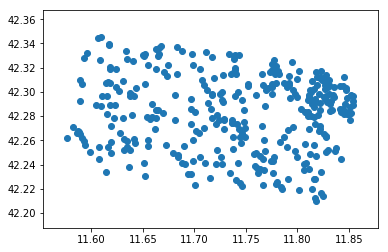

In [453]:
phatcoos = SkyCoord.guess_from_table(phat_data, unit=u.deg)
#plt.scatter(phatcoos.ra, phatcoos.dec, alpha=0.01, color='lightgrey')
plt.scatter(starcoos[acceptable_msata_star_msk].ra, starcoos[acceptable_msata_star_msk].dec)

In [454]:
# display the brick, and lower add markers for the acceptable MSATA reference stars
# scale will only allow a visual check that nothing is an artifact of or too near a very bright source
img1 = ImageWidget(image_width= 1024, image_height=600)
img1.load_fits(phat_ref_img)
img1

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [455]:
msata_stars.add_column(starcoos, name='SkyCoord')

In [456]:
# haven't cracked this yet... 
img1.add_markers(msata_stars[acceptable_msata_star_msk], skycoord_colname='SkyCoord', use_skycoord = True)

In [433]:
# use if you've already added markers
img1.remove_markers()

### Summary
Brick 11 is a no-go, even under the best of conditions (can have a close companion within 0.3 arcsec as long as fainter than F110W of 25, and using the brighter saturation limit of 19.0 for F110W vegamag normalizations that I found using the ETC).

Brick 19 -- marginal ~ 24 per MSA FOV with brighter saturationa limit, ~ 12 with fainter saturation limit.
The upper edge, and upper left corner of the brick (e.g., fields 1,2,3,4,5,7,8 have the most possible reference stars.

Brick 23 - looks doable ~70 per MSA FOV with brighter saturation limit, ~ 50 with fainter saturation limit
Any fields have fine numbers of reference stars.  center right of brick has some super bright stars to avoid as much as possible ('dragon's breath'...).  upper left has lots of available references stars, but also a few bright (but not as bright) sources.  more center/lower part of left half of brick might be preferable.